# Group 9: Provisional Neural Network Model
## Week 1

**COVID-19 Model**
1. Supervised Regresson to predict CoVID new_cases and new_deaths
2. (Potential second model) Unsupervised to determine predictive factors for number of cases and deaths.  

**Potential Limitations:**


Data Source: Our World in Data
https://github.com/owid/covid-19-data/tree/master/public/data



In [74]:
# Import  Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# import seaborn as sns (pip install)  -- https://www.tensorflow.org/tutorials/keras/regression


In [75]:
# Import Dataset
covid_data_raw_df = pd.read_csv('owid-covid-data.csv')
covid_data_raw_df.head()


# Import from Tan's provisional database

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


## 1. Preprocess Data

•	Provisionally, select desired columns

•	Clean data set


In [76]:
# Scale down data set to minimal data for model proof-of-concept (poc)
covid_data_poc_df = covid_data_raw_df[["location", "date", "new_cases", "new_deaths", "population"]]

# For proof-of-concept, focus on 1 country
covid_data_poc_df = covid_data_poc_df[covid_data_poc_df["location"] == "United States"]

covid_data_poc_df.head()

,location,date,new_cases,new_deaths,population
71614,United States,2020-01-22,NaN,NaN,331002647.0
71615,United States,2020-01-23,0.0,NaN,331002647.0
71616,United States,2020-01-24,1.0,NaN,331002647.0
71617,United States,2020-01-25,0.0,NaN,331002647.0
71618,United States,2020-01-26,3.0,NaN,331002647.0


In [77]:
# covid_data_poc_df shape
print('shape of array :', covid_data_poc_df.shape)

shape of array : (421, 5)


In [78]:
# Convert NAN to 0
covid_data_poc_df = covid_data_poc_df.fillna(0)
covid_data_poc_df.head()

,location,date,new_cases,new_deaths,population
71614,United States,2020-01-22,0.0,0.0,331002647.0
71615,United States,2020-01-23,0.0,0.0,331002647.0
71616,United States,2020-01-24,1.0,0.0,331002647.0
71617,United States,2020-01-25,0.0,0.0,331002647.0
71618,United States,2020-01-26,3.0,0.0,331002647.0


In [79]:
covid_data_poc_df.dtypes

location       object
date           object
new_cases     float64
new_deaths    float64
population    float64
dtype: object

In [80]:
# ***NEED TO PREPROCESS DATE SERIES DATA FOR SUPERVISED LEARNING MODEL****


# Convert date column to dtype datetime
covid_data_poc_df['date'] = pd.to_datetime(covid_data_poc_df['date'])

covid_data_poc_df.dtypes



# !!!!https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/!!!!!

# Deep learning methods are trained using supervised learning and expect data in the form of samples with inputs and outputs. 
#Time series are long sequences of numbers.
# ????How to transform a time series into a form suitable for supervised learning????



# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/







# https://towardsdatascience.com/preprocessing-time-series-data-for-supervised-learning-2e27493f44ae
    

# pd.DataFrame({
#     "t_2": df.head(11)["energy"].shift(2), 
#     "t_1": df.head(11)["energy"].shift(), 
#     "energy": df.head(11)["energy"]
# })


location              object
date          datetime64[ns]
new_cases            float64
new_deaths           float64
population           float64
dtype: object

## 2. Split Data into Training/Testing

Begin model with a **single variable** to verify proof-of-concept

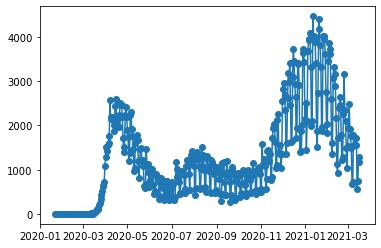

In [81]:
# Split preprocessed data into feature(s) and target
X = covid_data_poc_df['date']
y = covid_data_poc_df['new_deaths']


# Plot new-deaths data
plt.scatter(X, y)
plt.plot (X, y)
plt.show()

In [82]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(315,)
(106,)
(315,)
(106,)


## 3. Normalize/Standardize Numerical Features

**Using StandardScaler**

### No need to Normalize for a single feature proof-of-concept model

In [83]:
# # Create standard scaler instance
# X_scaler = StandardScaler()

# # Fit the scaler
# X_scaler.fit(X_train)

# # Scale both the training and testing data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)




# ***ValueError: could not convert string to float: '2020-02-12'

## 4. Build the Model

a. **Pick Model**: Deep Neural Net, Sequential

(https://www.tensorflow.org/tutorials/keras/regression)
b. **Input Layer**: Add the number of input features equal to the number of variables in the Feautures DataFrame

c. **Hidden Layers**: 2 hidden layers

    i. First: Use Keras Dense Class, 8 neurons, relu activation function to identify nonlinear characteristics
    
    ii. Second: Use Keras Dense Class, 5 neurons, relu activation function

d. **Output Layer**:  Sigmoid activation function to predict the probability that an employee is at risk for attrition

e. **Verify Model Structure**:

f. **Compile the Model and Define Loss / Accuracy Metrics**: Use  model as a binary classifier, use the **binary_crossentropy loss function**, **adam optimizer**, and **accuracy metrics** --same parameters used for our basic neural network. 

In [84]:
# Define the model - deep neural net
number_input_features = 1
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30

nn_provisional = tf.keras.models.Sequential()

# First hidden layer
nn_provisional.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# c.Second hidden layer
nn_provisional.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_provisional.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_provisional.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 80)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 31        
Total params: 2,621
Trainable params: 2,621
Non-trainable params: 0
_________________________________________________________________


In [85]:
# f. Compile the model
nn_provisional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])



## 5. Fit/Train the Model

a. Train model on training data

b. Evaluate model using test data (Loss and Accuracy.  

In [86]:
# a Train the model on training data
fit_model = nn_provisional.fit(X_train,y_train,epochs=10)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [87]:
# b. Evaluate the model using the test data
model_loss, model_accuracy = nn_provisional.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [88]:
# visualize model's loss over the full 100 epochs

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

NameError: name 'fit_model' is not defined

In [89]:
# Plot model's accuracy over all epochs
history_df.plot(y="accuracy")

NameError: name 'history_df' is not defined